<a href="https://colab.research.google.com/github/todnewman/coe_training/blob/master/LSTM_sequencing_data_multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Data Classification using LSTM
**Author**: W. Tod Newman

**New

## Problem

Predict the identity of an individual simply by three axes of accelerometer data.

This notebook shows how to take advantage of the information contained in sequences from time series data.  It shows how to convert time series data into dataframes useful for LSTM networks. 

Additionally, this notebook shows how to:
1.  Follow a managed workflow from Data to Verification.  This uses GitHub, Google Drive, and Tensorboard to demonstrate what a production workflow might look like.
2.  Connect a Keras/Tensorflow model with SKLearn and Pandas tools
3.  Use Tensorboard for Evaluating models

## Learning Objectives

1. Understand how to format (row,column) data into a 3D tensor suitable for an LSTM to process
2. Understand how to optimize an LSTM network
3. Understand the differences in the neural network architecture for binary classes and multiclass

## Dataset


*  Our dataset comes from UC Irvine's open data repository.  You can find it at https://archive.ics.uci.edu/ml/datasets/User+Identification+From+Walking+Activity
*  The dataset collects data from an Android smartphone positioned in the chest pocket. Accelerometer Data are collected from 22 participants walking in the wild over a predefined path. The dataset is intended for Activity Recognition research purposes. It provides challenges for identification and authentication of people using motion patterns.
  1. Sampling frequency of the accelerometer: DELAY_FASTEST with network connections disabled
  2. Number of Participants: 22
  3.  Data Format: CSV 
  
## Citation
  --- Casale, P. Pujol, O. and Radeva, P.
'Personalization and user verification in wearable systems using biometric walking patterns'
Personal and Ubiquitous Computing, 16(5), 563-580, 2012

In [0]:
import os, sys 
sys.path.insert(0, os.getcwd()) 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import matplotlib
import sklearn as sk
from sklearn import preprocessing
from sklearn import metrics
#from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn import linear_model
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)



# Mount Google Drive

If you have one, this is a convenient way to save off your model, etc.  The drive mounts at /content/drive/'My Drive'/

In [0]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/'My Drive'/data

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/data
 1_FBB_2017_matrix.png               PlayByPlay_2012.zip
 1_rain_confusion_matrix.png         PlayByPlay_2013.zip
 2_FBB_2017_matrix.png               PlayByPlay_2014.zip
 2_rain_confusion_matrix.png         PlayByPlay_2015.zip
 Cities.csv                          PlayByPlay_2016.zip
 Conferences.csv                     PlayByPlay_2017.zip
 ConferenceTourneyGames.csv          PlayByPlay_2018.zip
'Copy of quake_model_mlp'           

### Loading Data 

Here we load two different types of data.

1.  GitHub data.  The simple workflow that we use for CoLaboratory exercises has us loading data that we either develop ourselves or models that have demonstrated themselves to be worthy of configuration in GitHub.   We also store our tools library in GitHub for convenience.

2.  UC Irvine data.  The data we will use to train our LSTM comes from UC Irvine's Open Data repository.  Here we grab that data with wget and unzip it into the /content directory.

In [0]:
%cd /content
# Below is how you clone the whole data project from Tod's GitHub
#!git clone https://github.com/todnewman/data
# Below is how you can grab just the single .csv file for this project.  You can get this address by clicking on a file, then clicking 'RAW'
#  in GitHub.  Then copy the link address from the browser.

# Tod's function library
!wget -O /content/pytools.py 'https://raw.githubusercontent.com/todnewman/coe_training/master/pytools.py'
# Here's a model trained on around 3000 epochs that you can use as a starting point
!wget -O /content/id_model 'https://raw.githubusercontent.com/todnewman/models/master/id_model'

import pytools

# If you want to use Tensorboard, set this to True
tensorboard = False

# Load the actual accelerometer data from UC Irvine's Open Data repository
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00286/User%20Identification%20From%20Walking%20Activity.zip
!unzip 'User Identification From Walking Activity.zip'
%cd 'User Identification From Walking Activity'
%ls *.csv


/content
--2019-04-16 12:45:44--  https://raw.githubusercontent.com/todnewman/coe_training/master/pytools.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8563 (8.4K) [text/plain]
Saving to: ‘/content/pytools.py’

/content/pytools.py 100%[===================>]   8.36K  --.-KB/s    in 0s      

2019-04-16 12:45:44 (87.8 MB/s) - ‘/content/pytools.py’ saved [8563/8563]

--2019-04-16 12:45:46--  https://raw.githubusercontent.com/todnewman/models/master/id_model
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238376 (233K) [application/octet-s

## Connect Tensorboard

You don't have to use Tensorboard but it might be interesting as a verification tool.  If you wish to use it, it will provide an ngrok.io link that you can click to bring up your local instance of Tensorboard.

In [0]:
if not tensorboard:
    !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
    !unzip ngrok-stable-linux-amd64.zip
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
"import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

# Set the flag to True in case you didn't do it above.    
tensorboard = True

--2019-03-08 00:55:20--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.73.94.166, 52.7.169.168, 52.72.250.2, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.73.94.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14893410 (14M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  14.20M  11.5MB/s    in 1.2s    

2019-03-08 00:55:22 (11.5 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [14893410/14893410]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
https://ae65fd6f.ngrok.io


## Process DataFiles

We are grabbing all of the .csv files into a list and then adding the target vector (the ID for the individual).  Each of these files represents one individual.  We take them and append them into one large dataframe.

In [0]:
import subprocess 
files = subprocess.getstatusoutput("ls *.csv")
file_list = str(files[1]).split()
#file_list = ['10.csv', '12.csv', '20.csv', '4.csv']
final_df = pd.DataFrame()
for f in file_list:
    if 'None' in f:
        continue
        
    df = pd.read_csv(f, error_bad_lines=False, header=None) 
    f= f.replace('.csv', '')
    df['Target']=int(f)
    
    final_df = final_df.append(df)

[10 11 12 13 14 15 16 17 18 19  1 20 21 22  2  3  4  5  6  7  8  9]
               0         1       2        3  Target
0       0.000000 -1.838700  5.9385   4.2495      10
1       0.029786 -1.607200  5.5980   4.8216      10
2       0.060669 -0.844460  5.8976   6.6331      10
3       0.089905 -0.612920  7.7772   6.7421      10
4       0.120150 -1.076000  9.5342   6.7829      10
5       0.149840 -1.185000  9.5070   8.8941      10
6       0.179840 -0.721880  8.0088   9.2346      10
7       0.209900 -0.531190  7.6683  10.1880      10
8       0.239840  0.231550  8.2812   9.2346      10
9       0.269840  1.116900  8.7715   7.8862      10
10      0.299780  1.035100  8.4719   8.1586      10
11      0.329770  0.422230  7.3958   9.2346      10
12      0.359740  0.313270  5.8976   8.5808      10
13      0.389740  0.081722  5.8976   7.1234      10
14      0.419710  0.313270  5.9793   6.7421      10
15      0.449860  0.653780  6.1700   6.6604      10
16      0.479860  0.503950  6.0883   6.2790     

## Turning 2D Data into a 3D tensor

This is important for LSTM networks because they take a 3D tensor as input.  This means that you have a tensor of [samples, timesteps, features].

* samples: refers to the total number of "chunks" of data that gets created after reshaping.
* timesteps is how we define how many records we include in each chunk.  LSTM's work best with smaller numbers of timesteps.  Something between 30 and 200 (though papers indicate they can work up to 1000 timesteps)
* features are the number of columns in the tensor.

In [0]:
def process_3D_data(df, sample_depth, predict_flag, y_shift):
    from sklearn.model_selection import TimeSeriesSplit
    target = 'Target'
    print('df.shape', df.shape, df['Target'].unique())
    
    size = 0.4
    
    length = sample_depth
    samples = []
    test_samples = []
    training_samples = []
    pred_samples = []
    
    time = df.pop(0)
    n = df.shape[0]
    feat = df.shape[1]
    
    df[df.columns[0:feat-1]] = preprocessing.MinMaxScaler().fit_transform(df[df.columns[0:feat-1]])  # Exclude y from scaling.
    
    print (df[df.columns[:n]].describe())
    
    if not predict_flag: # We're Training       
        
        #
        # reshape into [samples, timesteps, features]
        for i in range(0, n, length):
            sample = np.array(df[i:i+length])
            if len(sample)==length:
                samples.append(sample)
        
        samples = np.array(samples)
        
        y_shape = samples.shape[2]
        
        y = samples[:,:,y_shape-1:y_shape]        
        X = samples[:,:,0:y_shape-1]
        
        y = np_utils.to_categorical(y)
        
        print("I", X.shape, y.shape)
        
        i = int((1 - size) * X.shape[0]) + 1
        train_y = y[:i, :, :]
        test_y = y[i:, :, :]
        train_X = X[:i, :, :]
        test_X = X[i:, :, :]


        print("post split", train_X.shape, train_y.shape, test_X.shape, test_y.shape)  
        dec_train = decode_one_hot(train_y)
        dec_test = decode_one_hot(test_y)
        print("unique vals:", np.unique(dec_train), np.unique(dec_test))
        
        
        return train_X, train_y, test_X, test_y
    
    else:  # We're Doing Inference
        X,y = non_shuffling_train_test_split(df, 0.25, predict_flag, target, y_shift)
        
        # reshape into [samples, timesteps, features]
        for i in range(0, n, length):
            sample = np.array(X[i:i+length])
            if len(sample)==length:
                pred_samples.append(sample)
        pred_samples = np.array(pred_samples)
        print(pred_samples.shape)
        
        return pred_samples, 0
        

## Here's our LSTM Model

* We're using ADAM as our optimizer.  This will automatically adjust learning rate as we train.
* Our loss function is categorical crossentropy and our metrics are categorical accuracy.  This is because we're doing multi-class classification (our 22 individuals)
* Note our final layer is a softmax.  This returns the probability of classification for each class in the network.

In [0]:
def nn_lstm(input_shape, final_layer, y_feat, learning_rate):
    print(y_feat)
    metrics=['categorical_accuracy']
    model = Sequential()
    model.add(LSTM(50, input_shape=(input_shape, final_layer), return_sequences=True))
    model.add(Dropout(0.5))    
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.5)) 
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.6)) 
    model.add(TimeDistributed(Dense(30, activation='relu')))
    model.add(TimeDistributed(Dense(y_feat, activation='softmax')))

    #model.add(Dense(y_feat, activation='softmax'))

    optimizer = optimizers.Adam(lr=learning_rate)
    model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=metrics)

    return model



## Convenience Functions

* decode_one_hot:  Allows us to reverse one-hot coding on our y vectors.  This helps when doing our model verification metrics.  For a great description of one-hot coding, see here (https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)

In [0]:
def decode_one_hot(y):
    decoded_y = []
    for i in range(0, y.shape[0]-1):
        dec = [ np.argmax(t) for t in y[i] ]
        decoded_y.append(dec)
    decoded_y = np.array(decoded_y)
    return decoded_y.flatten()

## Process Sequences through LSTM model

[10 11 12 13 14 15 16 17 18 19  1 20 21 22  2  3  4  5  6  7  8  9]
shapes: (89588, 5) (59744, 5)
df.shape (149332, 5) [10 11 12 13 14 15 16 17 18 19  1 20 21 22  2  3  4  5  6  7  8  9]
                   1              2              3         Target
count  149332.000000  149332.000000  149332.000000  149332.000000
mean        0.460749       0.645770       0.452687      13.897296
std         0.073728       0.090905       0.091706       5.921451
min         0.000000       0.000000       0.000000       1.000000
25%         0.422407       0.593137       0.400787       9.000000
50%         0.469691       0.648518       0.434119      16.000000
75%         0.502267       0.697206       0.481342      18.000000
max         1.000000       1.000000       1.000000      22.000000
I (2986, 50, 3) (2986, 50, 23)
post split (1792, 50, 3) (1792, 50, 23) (1194, 50, 3) (1194, 50, 23)
unique vals: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] [ 1  2  3  4  5  6  7  8  9 10 11 12 1

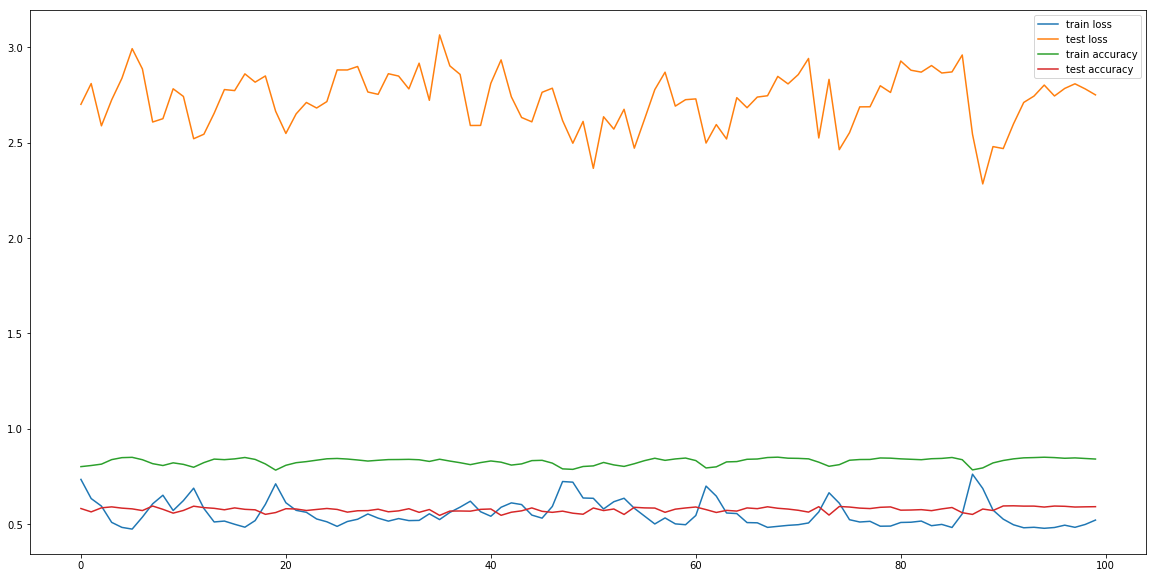

1194/1194 [==============================] - 1s 707us/step
Test set
  Loss: 2.750
  Accuracy: 0.593


In [0]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.layers import LSTM, Flatten, Dense, Activation, Dropout, TimeDistributed
from keras.models import Sequential
from sklearn.metrics import cohen_kappa_score
from keras.layers.advanced_activations import LeakyReLU
from sklearn.model_selection import cross_val_score
from keras import optimizers
from imblearn.combine import SMOTEENN
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
import pytools

num_epochs = 100  # adjust this depending on how many passes through the data you want

y_shift = 0
learning_rate = .005
sample_depth = 50
batch_size = 128
size = .6
retrain = False # Start over with new weights

#
#  This is where we will place our trained model
weights_file = '/content/id_model'

data_to_use = final_df.copy()
#
# load dataset
dataset = data_to_use
cols = (dataset.columns)
label_list = dataset['Target'].unique()
train_data = pd.DataFrame()
test_data = pd.DataFrame()

#
# Filter our large dataframe by label and split into test and train.
# I do this to ensure that we have each label split the same amount.
for label in label_list:
    filter = dataset['Target'] == label
    df_temp = dataset[filter]
    
    i = int((1 - size) * df_temp.shape[0]) + 1
    
    df_test = df_temp.iloc[:i, :]
    df_train = df_temp.iloc[i:, :]

    train_data = train_data.append(df_train)
    test_data = test_data.append(df_test)
    
print("shapes before splits:", "Train:", train_data.shape, "Test:", test_data.shape)
    
df_new = train_data.append(test_data)

train_X, train_y, test_X, test_y = process_3D_data(df_new, sample_depth, False, y_shift)
print("Data Shapes after one-hot coding:", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)

model = nn_lstm(train_X.shape[1], train_X.shape[2], train_y.shape[2], learning_rate)
if not retrain:
    model.load_weights(weights_file)

#
# Callback for TensorBoard for visual metrics
if tensorboard:
    tbCallBack = TensorBoard(log_dir='./log', histogram_freq=1,
                             write_graph=True,
                             write_grads=True,
                             batch_size=batch_size,
                             write_images=True)
#
# Fit the model based on everything we've defined to date.  Write metrics to 
# TensorBoard

if tensorboard:
    history = model.fit(train_X, train_y,            
                              batch_size=batch_size,
                              epochs=num_epochs,
                              verbose=False,
                              validation_data=(test_X, test_y), 
                              callbacks=[tbCallBack],
                              shuffle = False) 
#
# If we choose not to run Tensorboard we'll do early stopping for optimization.
# Not sure why, but Early Stopping and Tensorboard don't go together well.
else:
    history = model.fit(train_X, train_y,            
                              batch_size=batch_size,
                              epochs=num_epochs,
                              verbose=1,
                              validation_data=(test_X, test_y), 
                              callbacks=[early_stop],
                              shuffle = True) 
#
# Save off Model for use later

model.save_weights(weights_file, overwrite=True)

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# plot history
plt.figure( figsize=(20,10))
pyplot.plot(loss, label='train loss')
pyplot.plot(val_loss, label='test loss')
pyplot.plot(acc, label='train accuracy')
pyplot.plot(val_acc, label='test accuracy')
pyplot.legend()
pyplot.show()

accr = model.evaluate(test_X,test_y)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

config = model.get_config()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 50, 50)            10800     
_________________________________________________________________
dropout_17 (Dropout)         (None, 50, 50)            0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 50, 50)            20200     
_________________________________________________________________
dropout_18 (Dropout)         (None, 50, 50)            0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 50, 50)            20200     
_________________________________________________________________
dropout_19 (Dropout)         (None, 50, 50)            0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, 50, 30)            1530      
__________

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


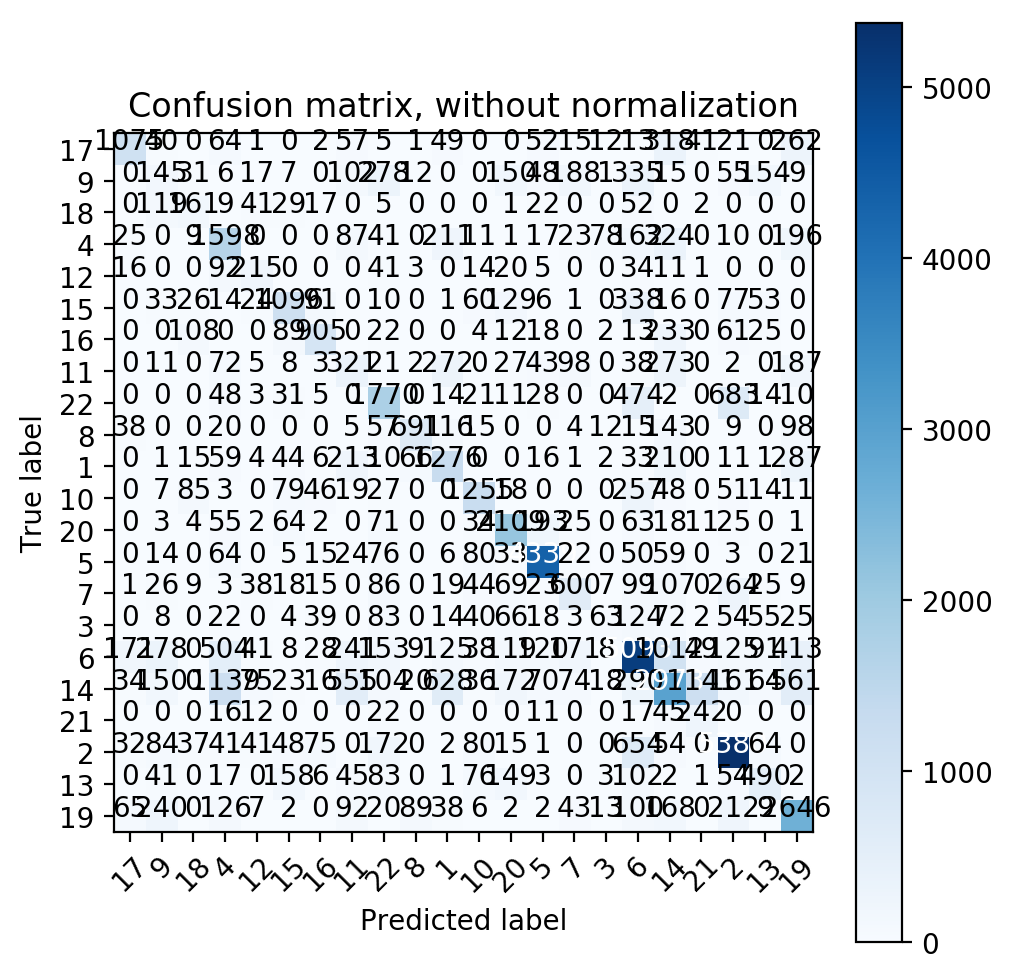

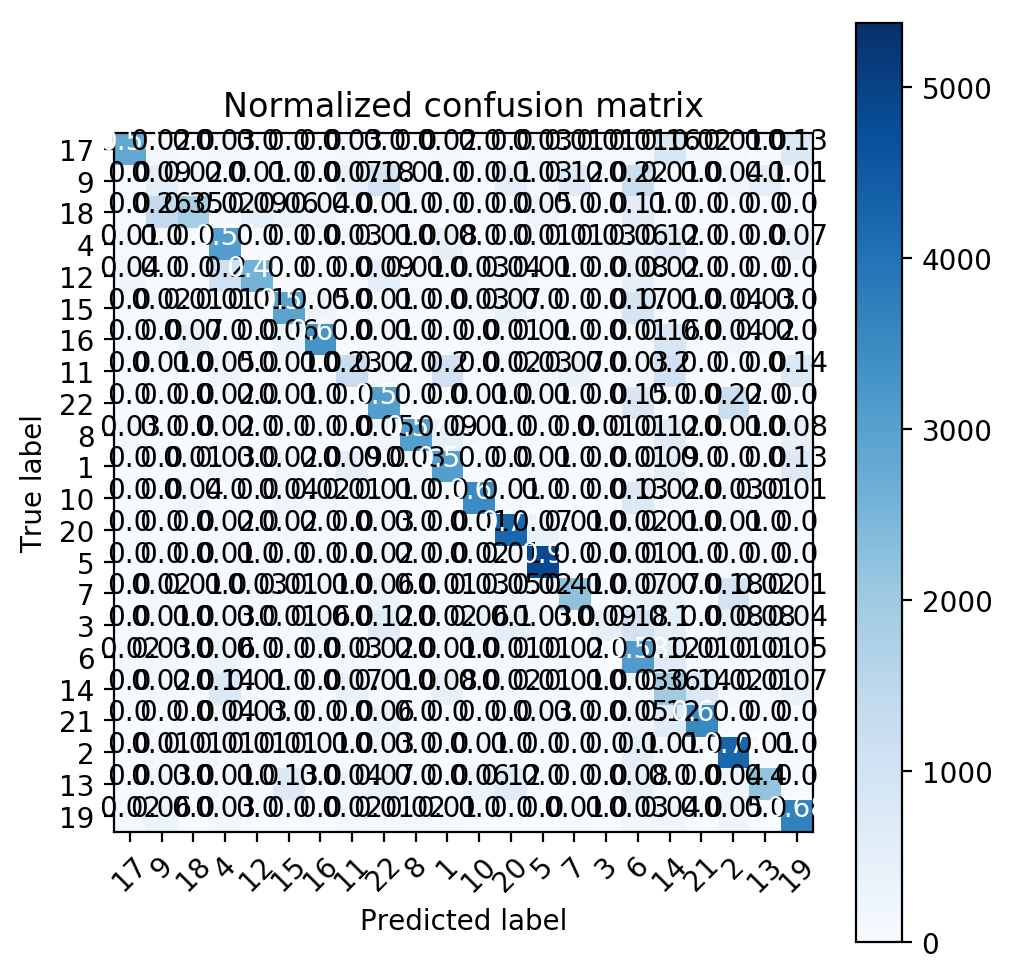

In [0]:
print(model.summary())
df_out = pd.DataFrame()
# make a prediction
yhat = model.predict(test_X)
yhat_cl = model.predict_classes(test_X)

decoded_y = decode_one_hot(test_y)
decoded_yhatcl = decode_one_hot(yhat_cl)
decoded_yhat = decode_one_hot(yhat)

df_out['yhat'] = pd.Series(decoded_yhat)
df_out['yhat_cl'] = pd.Series(decoded_yhatcl)
df_out['decoded_y'] = decoded_y
 
# summarize the fit of the model

print("Report that scores the ability of the model to predict the target on the test data:\n")

print(metrics.classification_report(decoded_y, decoded_yhat))
# The Kappa statistic (or value) is a metric that compares an Observed Accuracy with an 
# Expected Accuracy (random chance).  The kappa statistic can range between -1 and 1. 
# The maximum value means complete agreement; zero or lower means chance agreement.

ck_score = cohen_kappa_score(decoded_y, decoded_yhat)
print("Cohen-Kappa Score: %7.2f" % ck_score)

class_names = df_out['yhat'].unique()
pytools.call_confusion_matrix(decoded_y, decoded_yhat, class_names, 'id_confusion_matrix.png', 5)


In [0]:
weights_file = '/content/id_model'
model.save_weights(weights_file, overwrite=True)
%cd /content
%ls
%cp id_model /content/drive/'My Drive'/.



/content
 1_id_confusion_matrix.png
 1_rain_confusion_matrix.png
 2_id_confusion_matrix.png
 2_rain_confusion_matrix.png
 drive/
 id_model
 lightning_sensor_data.csv
 lightning_sensor_data_predict.csv
 __MACOSX/
 __pycache__/
 pytools.py
 rain_model_mlp
 reframed.csv
 sample_data/
'User Identification From Walking Activity'/
'User Identification From Walking Activity.zip'
